# XRay 

## Imports

In [2]:
import os
import csv
import xml.etree.ElementTree as ET
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import torch.nn.functional as F
from torchvision.utils import draw_bounding_boxes

## Setting-Up & Loading the Data

In [3]:
# # Set the environment variable for the VS Code session
# os.environ['XRAY_DATA_PATH'] = '/Users/pranavpai/Code/StatsML/Statisitcal_Machine_Learning_Project/XRay'
# # Use the XRAY_DATA_PATH environment variable
# base_path = os.getenv('XRAY_DATA_PATH')


os.environ['XRAY_DATA_PATH'] = r'C:\Users\Gaura\OneDrive\Desktop\GAURAV\Unimleb\COMP90051\Statisitcal_Machine_Learning_Project\XRay'
base_path = os.getenv('XRAY_DATA_PATH')
print(f"Base Path: {base_path}")

Base Path: C:\Users\Gaura\OneDrive\Desktop\GAURAV\Unimleb\COMP90051\Statisitcal_Machine_Learning_Project\XRay


In [4]:
# Function to convert XML to CSV
def xml_to_csv(xml_folder, output_csv):
    """
    Convert XML annotation files to a CSV file and save it to the specified folder.

    Parameters:
    xml_folder (str): Path to the folder containing XML files.
    output_csv (str): Path where the output CSV file will be saved.

    Returns:
    None: Writes the CSV file to the specified location. If the CSV file exists, exits early and prints a message.
    """
    if os.path.exists(output_csv):
        print(f"{output_csv} already exists. Skipping conversion.")
        return
    
    with open(output_csv, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        # Write the header row with all the relevant properties
        csvwriter.writerow(['filename', 'width', 'height', 'depth', 'class', 'pose', 'truncated', 'difficult', 'xmin', 'ymin', 'xmax', 'ymax'])
        
        # Iterate over all XML files in the folder
        for xml_file in os.listdir(xml_folder):
            if xml_file.endswith('.xml'):
                tree = ET.parse(os.path.join(xml_folder, xml_file))
                root = tree.getroot()

                # Extract filename, width, height, and depth
                filename = root.find('filename').text
                size = root.find('size')
                width = int(size.find('width').text)
                height = int(size.find('height').text)
                depth = int(size.find('depth').text)

                # Iterate over all object elements in the XML
                for obj in root.findall('object'):
                    label = obj.find('name').text
                    pose = obj.find('pose').text
                    truncated = int(obj.find('truncated').text)
                    difficult = int(obj.find('difficult').text)
                    bbox = obj.find('bndbox')
                    xmin = int(bbox.find('xmin').text)
                    ymin = int(bbox.find('ymin').text)
                    xmax = int(bbox.find('xmax').text)
                    ymax = int(bbox.find('ymax').text)

                    # Write data to CSV
                    csvwriter.writerow([filename, width, height, depth, label, pose, truncated, difficult, xmin, ymin, xmax, ymax])

    print(f"{output_csv} has been created successfully.")

if base_path is None:
    raise EnvironmentError("Environment variable 'XRAY_DATA_PATH' is not set.")

# Construct paths using the base_path from the environment variable
train_xml_folder = os.path.join(base_path, 'Train', 'Annotations')
test_xml_folder = os.path.join(base_path, 'Test', 'Annotations')

# Output CSV paths
train_output_csv = os.path.join(base_path, 'Train', 'train_annotations.csv')
test_output_csv = os.path.join(base_path, 'Test', 'test_annotations.csv')

# Convert XML to CSV for train and test datasets
xml_to_csv(train_xml_folder, train_output_csv)
xml_to_csv(test_xml_folder, test_output_csv)


C:\Users\Gaura\OneDrive\Desktop\GAURAV\Unimleb\COMP90051\Statisitcal_Machine_Learning_Project\XRay\Train\train_annotations.csv already exists. Skipping conversion.
C:\Users\Gaura\OneDrive\Desktop\GAURAV\Unimleb\COMP90051\Statisitcal_Machine_Learning_Project\XRay\Test\test_annotations.csv already exists. Skipping conversion.


In [5]:
# Load and display stats for Annotation CSV, and return DataFrame
def compute_csv_stats(csv_path, name):
    """
    Load a CSV file, compute basic statistics, and return the data as a DataFrame.

    Parameters:
    csv_path (str): The path to the CSV file containing annotations.
    name (str): Name to use in the printed output for the dataset.

    Returns:
    pd.DataFrame: A DataFrame containing the loaded CSV data with computed stats.
                  Returns None if an error occurs while loading the CSV.
    """

    try:
        # Load the CSV into a DataFrame
        df = pd.read_csv(csv_path)

        # Display basic stats
        print(f"--- Stats for {name} ---")
        print(f"Total Rows: {len(df)}")
        print(f"Unique Images: {df['filename'].nunique()}")

        # Show a summary of the dataset (describe numeric fields)
        print("\nSummary Statistics:")
        print(df.describe())
        
        # Add a blank line after each section for readability
        print("\n" * 3)

        # Return the DataFrame for later use
        return df

    except Exception as e:
        print(f"An error occurred while processing {name}: {e}")
        return None  # Return None if there's an error

# Now you can call the function and store the DataFrames
df_train_annotations = compute_csv_stats(train_output_csv, 'Training Annotations')
df_test_annotations = compute_csv_stats(test_output_csv, 'Testing Annotations')


--- Stats for Training Annotations ---
Total Rows: 16951
Unique Images: 7514

Summary Statistics:
              width        height    depth     truncated     difficult  \
count  16951.000000  16951.000000  16951.0  16951.000000  16951.000000   
mean     688.489706    584.593711      3.0      0.005958      0.003304   
std      255.679926    145.789029      0.0      0.076962      0.057384   
min      191.000000    178.000000      3.0      0.000000      0.000000   
25%      516.000000    495.000000      3.0      0.000000      0.000000   
50%      657.000000    578.000000      3.0      0.000000      0.000000   
75%      835.000000    651.000000      3.0      0.000000      0.000000   
max     1536.000000   1035.000000      3.0      1.000000      1.000000   

               xmin          ymin          xmax          ymax  
count  16951.000000  16951.000000  16951.000000  16951.000000  
mean     259.334848    266.568698    399.287948    386.344345  
std      211.341671    141.579021    212.37

In [6]:
# First 5 Rows of the Annotation dataframe (Train)
df_train_annotations.head()

,filename,width,height,depth,class,pose,truncated,difficult,xmin,ymin,xmax,ymax
0,P02192.jpg,843,716,3,gun,Unspecified,0,0,407,366,565,439
1,P02192.jpg,843,716,3,gun,Unspecified,0,0,282,138,456,275
2,P05825.jpg,380,538,3,plier,Unspecified,0,0,165,268,337,340
3,P05825.jpg,380,538,3,plier,Unspecified,0,0,182,259,305,322
4,P00785.jpg,582,508,3,plier,Unspecified,0,0,302,113,504,183


In [7]:
# First 5 Rows of the Annotation dataframe (Test)
df_test_annotations.head()

,filename,width,height,depth,class,pose,truncated,difficult,xmin,ymin,xmax,ymax
0,P07029.jpg,636,660,3,plier,Unspecified,0,0,171,338,269,447
1,P02151.jpg,848,684,3,wrench,Unspecified,0,0,395,13,618,110
2,P02151.jpg,848,684,3,plier,Unspecified,0,0,503,39,738,241
3,P02151.jpg,848,684,3,gun,Unspecified,0,0,354,79,538,196
4,P02151.jpg,848,684,3,gun,Unspecified,0,0,268,364,451,484


In [8]:
# Function to create a DataFrame for image statistics and display stats using PyTorch
def get_image_dataframe(image_folder, name):
    """
    Create a DataFrame containing image statistics and the actual image tensors for easy access.
    
    Parameters:
    image_folder (str): The path to the folder containing images.
    name (str): Name to use in the printed output for the dataset.
    
    Returns:
    pd.DataFrame: A DataFrame containing image filename, width, height, mode, and tensor of images.
    """
    
    image_stats = []
    
    # Iterate over all images in the folder
    for image_file in os.listdir(image_folder):
        if image_file.endswith(".jpg"):  # Process only jpg images
            image_path = os.path.join(image_folder, image_file)
            
            try:
                # Open the image using torchvision
                image = read_image(image_path)  # Loads the image as a tensor (C x H x W)
                
                # Get image dimensions
                height, width = image.shape[1], image.shape[2]  # (height, width from tensor)
                
                # Mode isn't as explicit in PyTorch as it is in PIL, so we assume all images are RGB for simplicity
                mode = "RGB" if image.shape[0] == 3 else "Grayscale"
                
                # Append the image stats along with the actual image tensor
                image_stats.append([image_file, width, height, mode, image])
            
            except Exception as e:
                print(f"Error processing {image_file}: {e}")
    
    # Convert the collected image stats into a DataFrame
    df_image_stats = pd.DataFrame(image_stats, columns=['filename', 'width', 'height', 'mode', 'tensor'])
    
    # Display basic stats
    print(f"--- Stats for {name} ---")
    print(f"Unique Images: {df_image_stats['filename'].nunique()}")

    # Show a summary of image dimensions
    print("\nSummary of Image Dimensions:")
    print(df_image_stats[['width', 'height']].describe())

    # Add a blank line after each section for readability
    print("\n" * 3)

    return df_image_stats

# Define the paths to the image folders
train_image_folder = os.path.join(base_path, 'Train', 'Images')
test_image_folder = os.path.join(base_path, 'Test', 'Images')

# Get DataFrame for train and test images and store the image tensors in the DataFrame
df_train_images = get_image_dataframe(train_image_folder, 'Training Images')
df_test_images = get_image_dataframe(test_image_folder, 'Testing Images')

--- Stats for Training Images ---
Unique Images: 7514

Summary of Image Dimensions:
             width       height
count  7514.000000  7514.000000
mean    668.855204   579.260980
std     256.761139   151.183067
min     191.000000   178.000000
25%     488.000000   486.000000
50%     638.000000   573.000000
75%     816.750000   649.000000
max    1536.000000  1035.000000




--- Stats for Testing Images ---
Unique Images: 836

Summary of Image Dimensions:
             width      height
count   836.000000   836.00000
mean    665.648325   583.13756
std     256.079686   149.08091
min     191.000000   178.00000
25%     488.000000   487.00000
50%     634.000000   571.00000
75%     818.000000   661.00000
max    1536.000000  1035.00000






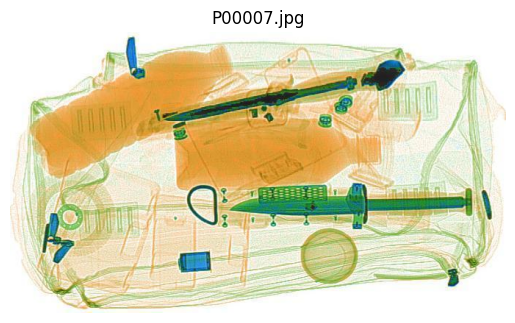

In [9]:
# Function to visualize an image tensor
def visualize_image(image_tensor, title="Image"):
    """
    Visualize a tensor image using matplotlib and return the figure.
    
    Parameters:
    image_tensor (torch.Tensor): The image tensor to visualize.
    title (str): The title of the image being displayed.
    
    Returns:
    matplotlib.figure.Figure: The figure object containing the plot.
    """
    try:
        # Check if the tensor is grayscale or RGB
        if image_tensor.shape[0] == 3:  # RGB
            # Convert tensor to numpy (C x H x W) -> (H x W x C)
            image_np = image_tensor.permute(1, 2, 0).numpy()
        elif image_tensor.shape[0] == 1:  # Grayscale
            # Squeeze the extra dimension for grayscale
            image_np = image_tensor.squeeze(0).numpy()
            plt.gray()  # Set the colormap to gray for visualization
        else:
            raise ValueError("Unexpected number of channels in the image tensor.")
        
        # Plot the image
        plt.imshow(image_np)
        plt.title(title)
        plt.axis('off')  # Hide axis
        plt.show()
    
    except Exception as e:
        print(f"Error visualizing image: {e}")

# Example: Visualize an image from the training set with a check for valid index
i = 5  # or any other index

# Ensure 'i' is within bounds
if i < len(df_train_images):
    visualize_image(df_train_images['tensor'][i], title=df_train_images['filename'][i])
else:
    print(f"Index {i} is out of range. The dataset contains {len(df_train_images)} images.")

In [ ]:
# First 5 Rows of the Image dataframe (Test)
df_test_images.head()

,filename,width,height,mode,tensor
0,P00001.jpg,681,549,RGB,"[[[tensor(255, dtype=torch.uint8), tensor(255,..."
1,P00010.jpg,685,416,RGB,"[[[tensor(255, dtype=torch.uint8), tensor(255,..."
2,P00013.jpg,686,362,RGB,"[[[tensor(255, dtype=torch.uint8), tensor(255,..."
3,P00022.jpg,696,389,RGB,"[[[tensor(255, dtype=torch.uint8), tensor(255,..."
4,P00024.jpg,586,610,RGB,"[[[tensor(255, dtype=torch.uint8), tensor(255,..."


## Functions 

In [10]:
torch_to_np = lambda tse : tse.permute(1, 2, 0).numpy()
np_to_torch = lambda npa : torch.from_numpy(npa).permute(2, 0, 1)

def show_image(pic, convert = False): 
  if (convert):
    pic = image.imread(pic) 
  print(f"dtype : {pic.dtype}")
  print(f"Shape : {pic.shape}") 
  print(f"Aspect Ratio (h/w) : {round(pic.shape[0]/pic.shape[1], 2)}")
  pyplot.imshow(pic)
  pyplot.show()
  
def remove_white(im, do_vertical = True, do_horizontal = True, v_whiteness_threshold = 80, h_whiteness_threshold = 80, seg_wid = 10, whiteness_tolerance = 33):  
  if (do_vertical):
    img_hig = im.shape[0]
    num_of_seg = int(img_hig/seg_wid)
    seg_num, iter, br, all_where = 0, 0, 0, 0
    v_dic = dict(zip([i for i in range(num_of_seg)], [-1 for i in range(num_of_seg)]))
    while (seg_num <= num_of_seg-br+2):
      if (all_where >= img_hig):
        break
      this_seg = im[seg_num*seg_wid:seg_num*seg_wid+seg_wid,:] 
      # print(f"VER this_seg = {this_seg.shape}") ###############################
      if (get_whiteness(this_seg, whiteness_tolerance)>v_whiteness_threshold):
        br += 1
        im = np.append(im[:seg_num*seg_wid,:], im[seg_num*seg_wid+seg_wid:,:], 0)
      else:
        v_dic[iter] = iter - br
        seg_num += 1
      iter += 1
      all_where += seg_wid
  
  # print(f"BEFORE HOR shape of im.shape = {im.shape}") 
  if (do_horizontal):
    img_wid = im.shape[1]
    num_of_seg = int(img_wid/seg_wid)
    seg_num, iter, br, all_where = 0, 0, 0, 0
    h_dic = dict(zip([i for i in range(num_of_seg)], [-1 for i in range(num_of_seg)]))
    while (seg_num <= num_of_seg-br+2):
      if (all_where >= img_wid):
        break
      this_seg = im[:,seg_num*seg_wid:seg_num*seg_wid+seg_wid]
      # print(f"HOR this_seg = {this_seg.shape}") ###############################
      if (get_whiteness(this_seg, whiteness_tolerance)>h_whiteness_threshold):
        br += 1
        im = np.append(im[:,:seg_num*seg_wid], im[:,seg_num*seg_wid+seg_wid:], 1)
      else:
        h_dic[iter] = iter - br
        seg_num += 1
      iter += 1
      all_where += seg_wid
  max_val_v_dic = max(v_dic.values())
  for k, v in v_dic.items():
    if (v == 0):
      for i in range(k):
        v_dic[i] = 0
    if (v == max_val_v_dic):
      for i in range(k, len(v_dic)):
        v_dic[i] = max_val_v_dic
  max_val_h_dic = max(h_dic.values())
  for k, v in h_dic.items():
    if (v == 0):
      for i in range(k):
        h_dic[i] = 0
    if (v == max_val_h_dic):
      for i in range(k, len(h_dic)):
        h_dic[i] = max_val_h_dic 
    return (seg_wid, h_dic, v_dic, im)
    
def get_whiteness(im, whiteness_tolerance = 30, mean = (104, 117, 123)):  
  mn_np = np.array(mean)
  if isinstance(im, torch.Tensor):
    im = im.numpy()
  im  = im + mn_np
  im = im.reshape((im.shape[0]*im.shape[1],3))
  white_count = 0
  for tup in im:
    if (255-sum(tup)/3 <= whiteness_tolerance):
    # if (sum(tup)/3 <= whiteness_tolerance):
      white_count += 1
  white_per = 100*white_count/len(im) 
  # print(f"white_per = {white_per}")   
  return round(white_per, 2)   

class BaseTransform:
    def __init__(self, resize= (584, 688), rgb_means=(104, 117, 123), transform_ = "medium"):
        self.resize = resize
        self.rgb_means = torch.tensor(rgb_means).view(3, 1, 1)
        self.transform_ = transform_

    def __call__(self, img):
        img = self.resize_image(img)
        
        if self.transform_ == "light":
            img = img + self.rgb_means
        elif self.transform_ == "dark":
            img = img - self.rgb_means            
        
        return img

    def resize_image(self, img):
        img = F.interpolate(img.unsqueeze(0), size= self.resize, mode='bilinear', align_corners=False).squeeze(0)
        return img

def reflect(old_w, w_max):
    mid_w = w_max//2
    if(mid_w < old_w):
        new_w = old_w - 2*(old_w - mid_w)
    else:
        new_w = old_w + 2*(mid_w - old_w)
    return new_w

def get_nearest_obj(tran_dic, seg_X):
  seg_X = int(seg_X)
  if (tran_dic[seg_X] != -1):
    return seg_X
  bfl = list(tran_dic.keys())[:seg_X]
  bfl = bfl[::-1]
  bf_counter = 0
  bf_seg = -1
  for bf in bfl:
    bf_counter += 1
    if (tran_dic[bf] != -1):
      bf_seg = bf
      break
  if (bf_seg == -1):
    bf_counter = 9999

  afl = list(tran_dic.keys())[seg_X+1:]
  af_counter = 0
  af_seg = -1
  for af in afl:
    af_counter += 1
    if (tran_dic[af] != -1):
      af_seg = af
      break
  if (af_seg == -1):
    af_counter = 9999

  if (bf_counter <= af_counter):
    new_seg = bf_seg
  else:
    new_seg = af_seg
  return new_seg

def rotated_this(old_x, old_y, xmax, ymax):
  new_org_x, new_org_y = (0, xmax)
  return (new_org_x+old_y, new_org_y-old_x)

## White Space Removal and resizing

1. Image Resizing and Cropping: Resize all images to a fixed size (e.g., 224x224 for a standard input to CNNs). Crop any excess white spaces to focus on the region of interest, which will help the network focus on the object areas. The bounding box coordinates will need to be updated as well (If needed, but gaurav said otherwise, so cross-check again)

torch.Size([3, 714, 1536])
dtype : torch.uint8
Shape : torch.Size([714, 1536, 3])
Aspect Ratio (h/w) : 0.46


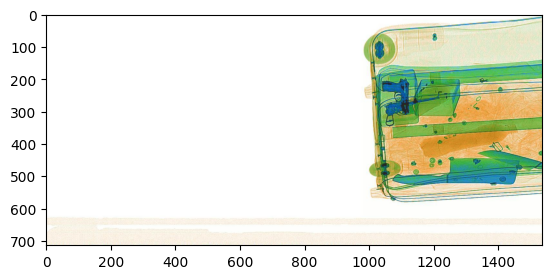

#### white removed no_whi_np.shape = (535, 532, 3)
dtype : uint8
Shape : (535, 532, 3)
Aspect Ratio (h/w) : 1.01


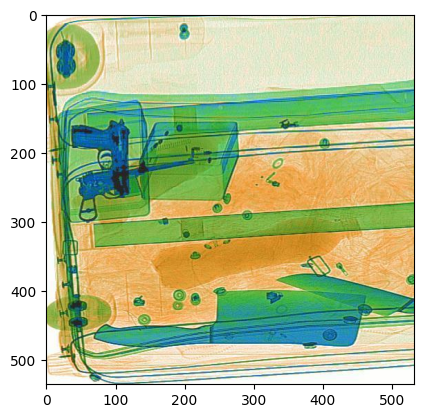

torch.Size([3, 611, 1536])
dtype : torch.uint8
Shape : torch.Size([611, 1536, 3])
Aspect Ratio (h/w) : 0.4


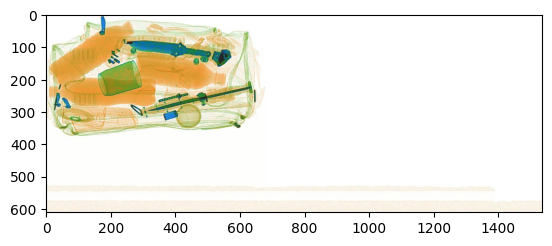

#### white removed no_whi_np.shape = (337, 582, 3)
dtype : uint8
Shape : (337, 582, 3)
Aspect Ratio (h/w) : 0.58


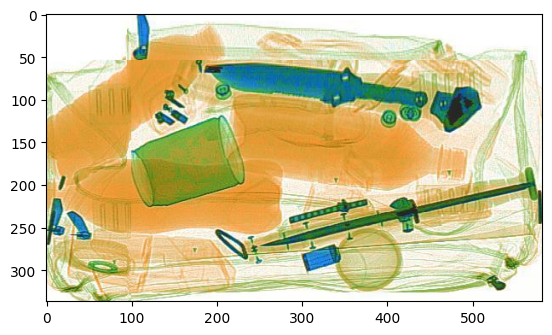

In [11]:
this_pic = df_train_images['tensor'][14]
print(this_pic.shape)
show_image(this_pic.permute(1, 2, 0), convert = False)
hld = 99.9
seg_size, h_tran, v_tran, no_whi_np = remove_white(im = this_pic.permute(1, 2, 0), v_whiteness_threshold = hld, h_whiteness_threshold = hld, seg_wid = 1)
print(f"#### white removed no_whi_np.shape = {no_whi_np.shape}")
show_image(no_whi_np)


this_pic = df_train_images['tensor'][15]
print(this_pic.shape)
show_image(this_pic.permute(1, 2, 0), convert = False)
hld = 99.9
seg_size, h_tran, v_tran, no_whi_np = remove_white(im = this_pic.permute(1, 2, 0), v_whiteness_threshold = hld, h_whiteness_threshold = hld, seg_wid = 1)
print(f"#### white removed no_whi_np.shape = {no_whi_np.shape}")
show_image(no_whi_np)

dtype : uint8
Shape : (707, 1155, 3)
Aspect Ratio (h/w) : 0.61


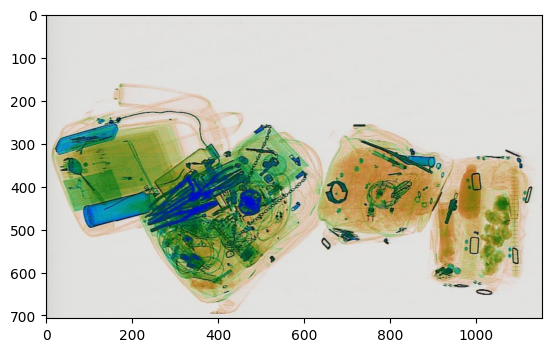

dtype : uint8
Shape : (707, 1155, 3)
Aspect Ratio (h/w) : 0.61


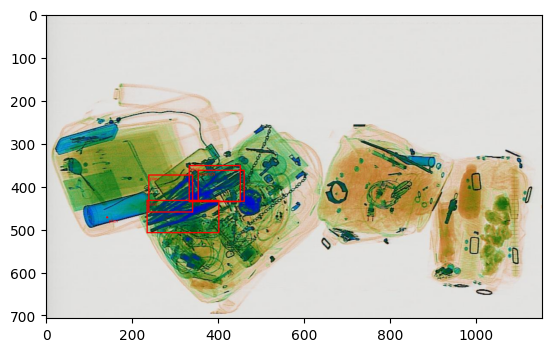

dtype : uint8
Shape : (436, 1078, 3)
Aspect Ratio (h/w) : 0.4


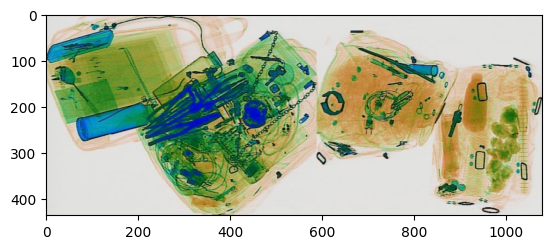

dtype : uint8
Shape : (436, 1078, 3)
Aspect Ratio (h/w) : 0.4


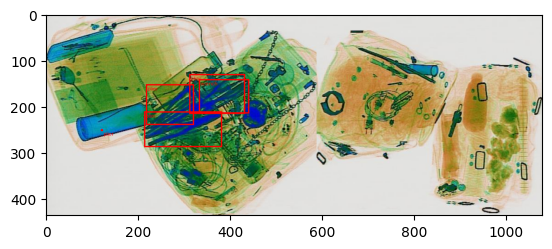

dtype : uint8
Shape : (584, 688, 3)
Aspect Ratio (h/w) : 0.85


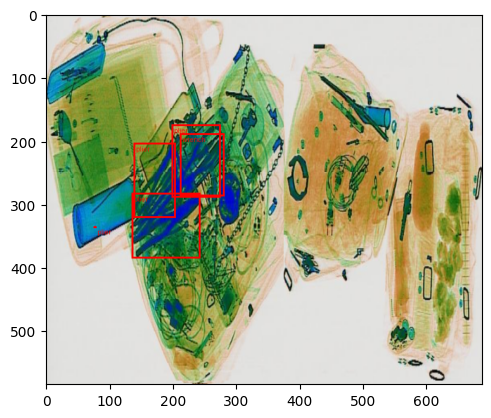

In [12]:

######################################################################################################
################################################### ORIGINAL ###################################################
######################################################################################################

# fi = 14
# fi = 99
# fi = 13
# fi = 3136

fi = 4456   #######
ann_pic = df_train_images['tensor'][fi]
ann_pic_name = df_train_images['filename'][fi]
show_image(torch_to_np(ann_pic))



######################################################################################################
################################################### ORIGINAL WITH BOXES ###################################################
######################################################################################################


xml_file_path = os.path.join(r"C:\Users\Gaura\OneDrive\Desktop\GAURAV\Unimleb\COMP90051\Statisitcal_Machine_Learning_Project\XRay\Train\Annotations", ann_pic_name[:-4] + ".xml")
tree = ET.parse(xml_file_path)
root = tree.getroot()

i = 0
obj_id = []
for child in root:
  if (child.tag == "object"):
    obj_id.append(i)
  i += 1

dim_dic = {}
count = 0
for i in obj_id:
  dim_dic[count] = {}
  dim_dic[count]["xmin"] = int(root[i][4][0].text)
  dim_dic[count]["ymin"] = int(root[i][4][1].text)
  dim_dic[count]["xmax"] = int(root[i][4][2].text)
  dim_dic[count]["ymax"] = int(root[i][4][3].text)
  dim_dic[count]["name"] = root[i][0].text
  count += 1
dim_dic

boxes = []
labels = []
for key, value in dim_dic.items():
    boxes.append([value['xmin'], value['ymin'], value['xmax'], value['ymax']])
    labels.append(value['name'])

boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
image_with_boxes = draw_bounding_boxes(ann_pic, boxes_tensor, labels=labels, colors="red", width=3)

show_image(torch_to_np(image_with_boxes))

# image_with_boxes_pil = torchvision.transforms.ToPILImage()(image_with_boxes)
# plt.imshow(image_with_boxes_pil)
# plt.title("Image with Bounding Boxes")
# plt.axis("off")  
# plt.show()


######################################################################################################
################################################### NO WHITE SPACES ###################################################
######################################################################################################


hld = 99.9
seg_size, h_tran, v_tran, no_whi_np = remove_white(im = torch_to_np(ann_pic), v_whiteness_threshold = hld, h_whiteness_threshold = hld, seg_wid = 1)
show_image(no_whi_np)


########## EXTRACTING object location from annotation files ##########
i = 0
obj_id = []
for child in root:
  if (child.tag == "object"):
    obj_id.append(i)
  i += 1

dim_dic = {}
count = 0
for i in obj_id:
  dim_dic[count] = {}
  dim_dic[count]["xmin"] = int(root[i][4][0].text)
  dim_dic[count]["ymin"] = int(root[i][4][1].text)
  dim_dic[count]["xmax"] = int(root[i][4][2].text)
  dim_dic[count]["ymax"] = int(root[i][4][3].text)
  dim_dic[count]["name"] = root[i][0].text
  count += 1

dim_dic_c = {}
count = 0
for i in obj_id:
  dim_dic_c[count] = {}
  dim_dic_c[count]["xmin"] = int(root[i][4][0].text)
  dim_dic_c[count]["ymin"] = int(root[i][4][1].text)
  dim_dic_c[count]["xmax"] = int(root[i][4][2].text)
  dim_dic_c[count]["ymax"] = int(root[i][4][3].text)
  dim_dic_c[count]["name"] = root[i][0].text
  count += 1
bbox0_list = []
for bb in dim_dic.values():
  temp = []
  temp.append(bb["ymin"])
  temp.append(bb["xmin"])
  temp.append(bb["ymax"])
  temp.append(bb["xmax"])
  bbox0_list.append(temp)
bbox0 = np.array(bbox0_list)
c_bbox = bbox0

######################################################################################################
################################################### Objects location after Removing white space ###################################################
##################################################################################################


w_bbox = []
for box in c_bbox: 
  temp_box = []
  y_min = box[0]
  x_min = box[1]
  y_max = box[2]
  x_max = box[3]
  y_min_seg = y_min//seg_size
  x_min_seg = x_min//seg_size  
  y_max_seg = y_max//seg_size
  x_max_seg = x_max//seg_size
  y_min_seg = y_min//seg_size
  x_min_seg = x_min//seg_size  
  y_max_seg = y_max//seg_size
  x_max_seg = x_max//seg_size
  if (x_min_seg <= 0):
    x_min_seg = min(h_tran.keys())
  if (y_min_seg <= 0):
    y_min_seg = min(v_tran.keys())
  if (x_max_seg >= len(h_tran)):
    x_max_seg = max(h_tran.keys())
  if (y_max_seg >= len(v_tran)):
    y_max_seg = max(v_tran.keys())

  if (v_tran[y_min_seg] == -1):
    y_min_seg = get_nearest_obj(tran_dic = v_tran, seg_X = y_min_seg)
  if (h_tran[x_min_seg] == -1):
    x_min_seg = get_nearest_obj(tran_dic = h_tran, seg_X = x_min_seg)
  if (v_tran[y_max_seg] == -1):
    y_max_seg = get_nearest_obj(tran_dic = v_tran, seg_X = y_max_seg)
  if (h_tran[x_max_seg] == -1):
    x_max_seg = get_nearest_obj(tran_dic = h_tran, seg_X = x_max_seg)
  w_y_min = seg_size*v_tran[y_min_seg] + y_min%seg_size
  w_x_min = seg_size*h_tran[x_min_seg] + x_min%seg_size
  w_y_max = seg_size*v_tran[y_max_seg] + y_max%seg_size
  w_x_max = seg_size*h_tran[x_max_seg] + x_max%seg_size
  temp_box.append(w_y_min)
  temp_box.append(w_x_min)
  temp_box.append(w_y_max)
  temp_box.append(w_x_max)
  w_bbox.append(temp_box)

######### pic display

boxes = []
labels = []
for key, value in dim_dic.items():
    boxes.append([value['xmin'], value['ymin'], value['xmax'], value['ymax']])
    labels.append(value['name'])

rot_c_bbox = []
for box in w_bbox:
    rot_x1, rot_y1 = rotated_this(old_x = box[1], old_y =box[0], xmax=no_whi_np.shape[1], ymax=no_whi_np.shape[0])
    rot_x2, rot_y2 = rotated_this(old_x = box[3], old_y =box[2], xmax=no_whi_np.shape[1], ymax=no_whi_np.shape[0])
    rot_c_bbox.append([ rot_y2, rot_x1, rot_y1, rot_x2])
W_boxes = [[int(x) for x in row] for row in rot_c_bbox]


h_max, w_max, _ = no_whi_np.shape
res = []
for bx in W_boxes:
    wmin_, hmin_, wmax_, hmax_ = bx[0], bx[1], bx[2], bx[3],
    this_box_X = [reflect(old_w = wmax_, w_max = w_max),  hmin_, reflect(old_w = wmin_, w_max = w_max),  hmax_]
    res.append(this_box_X)

W_boxes = res

boxes_tensor = torch.tensor(W_boxes, dtype=torch.float32)
image_with_boxes = draw_bounding_boxes(np_to_torch(no_whi_np), boxes_tensor, labels=labels, colors="red", width=3)
show_image(torch_to_np(image_with_boxes))

######################################################################################################
################################################### Resizing to 584 x 688 ###################################################
##################################################################################################

# transform = BaseTransform(transform_= "light")
transform = BaseTransform(transform_= "medium")
# transform = BaseTransform(transform_= "dark")
transformed_pic = transform(np_to_torch(no_whi_np))

transformed_pic_np = torch_to_np(transformed_pic)
Hratio = transformed_pic_np.shape[1]/no_whi_np.shape[1]
Wratio = transformed_pic_np.shape[0]/no_whi_np.shape[0]

ratioLst = [Hratio, Wratio, Hratio, Wratio]
w_bbox_r = []
for box in W_boxes:
    box = [int(a * b) for a, b in zip(box, ratioLst)] 
    w_bbox_r.append(box)

boxes_tensor = torch.tensor(w_bbox_r, dtype=torch.float32)
resized_image_with_boxes = draw_bounding_boxes(transformed_pic, boxes_tensor, labels=labels, colors="red", width=3)

show_image(torch_to_np(resized_image_with_boxes), convert = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [104..366].


Original shape: torch.Size([3, 436, 1078])
Transformed shape: torch.Size([3, 584, 688])
dtype : int64
Shape : (584, 688, 3)
Aspect Ratio (h/w) : 0.85


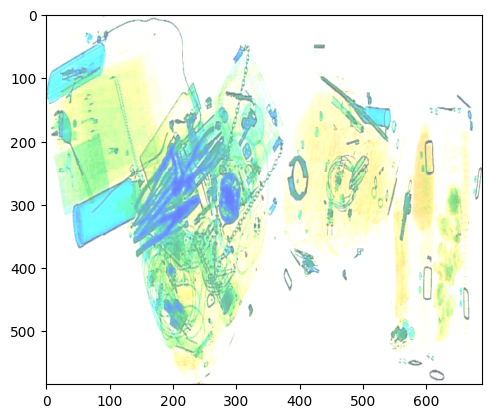

Original shape: torch.Size([3, 436, 1078])
Transformed shape: torch.Size([3, 584, 688])
dtype : uint8
Shape : (584, 688, 3)
Aspect Ratio (h/w) : 0.85


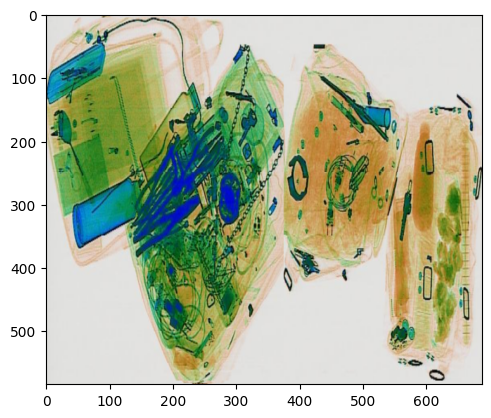

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123..147].


Original shape: torch.Size([3, 436, 1078])
Transformed shape: torch.Size([3, 584, 688])
dtype : int64
Shape : (584, 688, 3)
Aspect Ratio (h/w) : 0.85


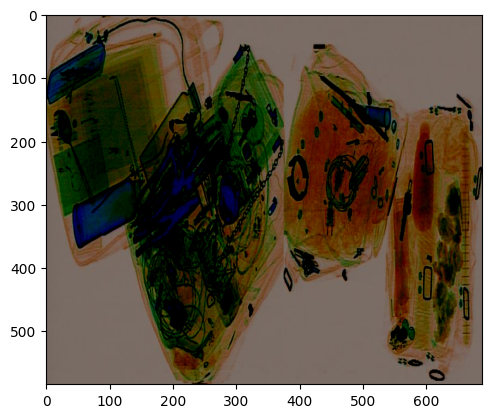

In [13]:

############################################################
############### Light ##################
############################################################

transform = BaseTransform(transform_= "light")
transformed_pic = transform(np_to_torch(no_whi_np))
print("Original shape:", np_to_torch(no_whi_np).shape)
print("Transformed shape:", transformed_pic.shape)
show_image(torch_to_np(transformed_pic), convert = False)

############################################################
############### Medium ##################
############################################################


transform = BaseTransform(transform_= "medium")
transformed_pic = transform(np_to_torch(no_whi_np))
print("Original shape:", np_to_torch(no_whi_np).shape)
print("Transformed shape:", transformed_pic.shape)
show_image(torch_to_np(transformed_pic), convert = False)

############################################################
############### Dark ##################
############################################################

transform = BaseTransform(transform_= "dark")
transformed_pic = transform(np_to_torch(no_whi_np))
print("Original shape:", np_to_torch(no_whi_np).shape)
print("Transformed shape:", transformed_pic.shape)
show_image(torch_to_np(transformed_pic), convert = False)